In [1]:
# This script is a demo for reconstructing linear events via High-resolution Linear Radon transform

import numpy as np
import matplotlib.pyplot as plt

def radon_op(din,param,oper):
    h=param['h']
    v=param['v']
    nt=param['nt']
    dt=param['dt']
    type=param['type']
    
    nh=len(h)
    nv=len(v)
    
    if oper == -1:
        m=np.zeros([nt,nv]);
       
    if oper == 1:
        d=np.zeros([nt,nh]);
    
    if oper == -1:
        d=din;
        
    if oper == 1:
        m=din;
        
    for itau in range(1,nt+1):
        for ih in range(1,nh+1):
            for iv in range(1,nv+1):
                
                if type==1:
                    t = (itau-1)*dt + h[ih-1]/v[iv-1];
                    it = np.floor(t/dt)+1;
                    it=np.int32(it);
                elif type==2:
                    t = (itau-1)*dt + h[ih-1]*h[ih-1]*v[iv-1]/hmax/hmax;   
                    it = np.floor(t/dt)+1;
                    it=np.int32(it);
                elif type==3:
                    t = np.sqrt (((itau-1)*dt)*((itau-1)*dt) + (h[ih-1]/v[iv-1])*(h[ih-1]/v[iv-1]) ) ;
                    it = np.floor(t/dt)+1;
                    it=np.int32(it);
                else:
                    t = np.sqrt (((itau-1)*dt)*((itau-1)*dt) + (h[ih-1]/v[iv-1])*(h[ih-1]/v[iv-1]) ) ;
                    it = np.floor(t/dt)+1;
                    it=np.int32(it);
                    
                if it <= nt and it-1>0:
                    if oper == -1:
                        m[itau-1,iv-1] = m[itau-1,iv-1] + d[it-1,ih-1];
                    if oper == 1:
                        d[it-1,ih-1]  = d[it-1,ih-1] + m[itau-1,iv-1];
    if oper == 1:
        return d;
    if oper == -1:
        return m;
    
def ricker(f,dt,tlength=None):
	# ricker: Ricker wavelet of central frequency f.
	#
	# INPUT:
	# f : central freq. in Hz (f <<1/(2dt) )
	# dt: sampling interval in sec
	# tlength : the duration of wavelet in sec
	#
	# OUTPUT: 
	# w:  the Ricker wavelet
	# tw: time axis
	#
	# Example
	#
	#   [w,tw] = str_ricker(10,0.004,0.2);
	#    plot(tw,w);
	import numpy as np
	
	if tlength!=None:
		nw=np.floor(tlength/dt)+1;
	else:
		nw=2.2/f/dt;
		nw=2*np.floor(nw/2)+1;
	nc=np.floor(nw/2);
	nw=int(nw)
	w =np.zeros(nw);
	
	k=np.arange(1,nw+1,1);
	alpha = (nc-k+1)*f*dt*np.pi;
	beta=np.power(alpha,2);
	w = (1.-beta*2)*np.exp(-beta);
	tw = -(nc+1-k)*dt;
	return w,tw

In [2]:
dp=0.05;dh=0.1;

h=np.linspace(0,6,int(6/dh+1));

nh=len(h);
p=np.linspace(-0.6,0.60,int(1.21/dp)+1);
nnp=len(p);

dt=0.2;nt=501;
m=np.zeros([nt,nnp]);
d=np.zeros([nt,nh]);
w,tw=ricker(0.5,dt);

In [3]:
tau=[100,200,250];
p0=[0,0.1,0.1];

In [4]:
m[tau[0]-1,12]=1;
m[tau[1]-1,18]=0.4;
m[tau[2]-1,18]=0.5;
# t = np.convolve(m[:,1],w,'same');
import scipy.signal
w=np.expand_dims(w,1);
m=scipy.signal.convolve2d(m,w,'same');

par={'h':h,'v':1/(p+0.00000000001),'nt':nt,'dt':dt,'type':1}

d=radon_op(m,par,1);


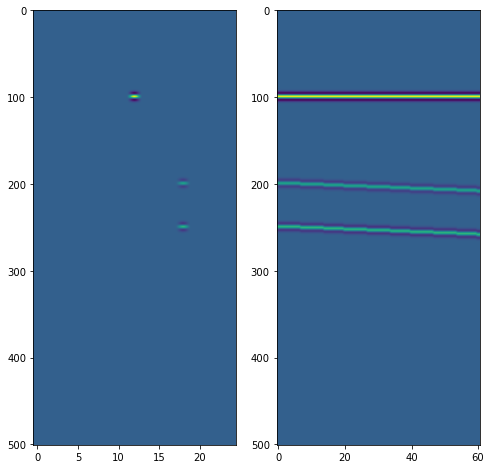

In [5]:
plt.figure(figsize=(8, 8));
plt.subplot(1,2,1)
plt.imshow(m,aspect='auto');
plt.subplot(1,2,2)
plt.imshow(d,aspect='auto');
plt.show()